In [1]:
import pandas as pd
import numpy as np
import json
import seaborn as sns
import matplotlib.pyplot as plt

file = 'data_set_ALL_AML_train.csv'
df = pd.read_csv(file, index_col=1)

In [2]:
#print(df.loc[1240:1250,'Gene Description':'Gene Accession Number'])
print(df.info())
print(df.shape)
a = ['call'] + ['call.' + str(x) for x in range(1,38)]
data = df.drop(columns=a)
print(data.shape)

<class 'pandas.core.frame.DataFrame'>
Index: 7129 entries, AFFX-BioB-5_at to Z78285_f_at
Data columns (total 77 columns):
Gene Description    7129 non-null object
1                   7129 non-null int64
call                7129 non-null object
2                   7129 non-null int64
call.1              7129 non-null object
3                   7129 non-null int64
call.2              7129 non-null object
4                   7129 non-null int64
call.3              7129 non-null object
5                   7129 non-null int64
call.4              7129 non-null object
6                   7129 non-null int64
call.5              7129 non-null object
7                   7129 non-null int64
call.6              7129 non-null object
8                   7129 non-null int64
call.7              7129 non-null object
9                   7129 non-null int64
call.8              7129 non-null object
10                  7129 non-null int64
call.9              7129 non-null object
11                  7129 no

In [3]:
key = pd.read_csv('actual.csv', index_col=0)
print(key.head())
print(type(key.index))

        cancer
patient       
1          ALL
2          ALL
3          ALL
4          ALL
5          ALL
<class 'pandas.core.indexes.numeric.Int64Index'>


I want to merge the gene expression dataframe ('data') with the key to create a dataframe that includes information on the type of cancer. I can then groupby the 'cancer' column to perform aggregations such as determining the mean and standard deviation of the expression level for each gene in the dataset.

In order to merge the 'data' and 'key' dataframes, however, I first need to reshape the data.

In [4]:
#Transpose rows and columns so that each column is a different gene
transposed_data = data.transpose()

#Drop the 'Gene Description' row as it is not useful here
cleaned_data = transposed_data.drop(['Gene Description'])
cleaned_data.index = cleaned_data.index.map(int)
print(cleaned_data.info())

#Convert columns to numeric datatypes instead of objects
cleaned_data = cleaned_data.apply(pd.to_numeric, errors='coerce')

#print first column of data as a check
#print(cleaned_data.iloc[:, 0:1])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38 entries, 1 to 33
Columns: 7129 entries, AFFX-BioB-5_at to Z78285_f_at
dtypes: object(7129)
memory usage: 2.1+ MB
None


In [5]:
#Merge the key dataframe with the trimmed dataframe to assign the cancer type to each patient sample
exp_data = pd.concat([key, cleaned_data], axis=1, join='inner')

#Check that output has the expected shape
print(exp_data.shape)

#Check against previous printout to confirm data is intact
#print(exp_data.iloc[:, 0:2])

#Group by cancer type to aggregate and calculate useful statistical information with describe()
stats = exp_data.groupby('cancer').describe()
print(stats)

(38, 7130)
       A28102_at                                                            \
           count        mean         std   min    25%    50%    75%    max   
cancer                                                                       
ALL         27.0  258.555556  203.127723  20.0  112.5  216.0  385.5  872.0   
AML         11.0  316.090909  126.132830  50.0  254.5  324.0  385.0  486.0   

       AB000114_at              ...    Z97074_at        hum_alu_at  \
             count       mean   ...          75%    max      count   
cancer                          ...                                  
ALL           27.0  40.296296   ...        256.5  567.0       27.0   
AML           11.0   6.090909   ...        122.0  205.0       11.0   

                                                                                
                mean          std      min      25%      50%      75%      max  
cancer                                                                          
ALL 

In [6]:
#Transpose dataframe so that genes form the rows
df = stats.transpose()
print(df.head(8))
print(df.shape)
print(df.info())

cancer                  ALL         AML
A28102_at count   27.000000   11.000000
          mean   258.555556  316.090909
          std    203.127723  126.132830
          min     20.000000   50.000000
          25%    112.500000  254.500000
          50%    216.000000  324.000000
          75%    385.500000  385.000000
          max    872.000000  486.000000
(57032, 2)
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 57032 entries, (A28102_at, count) to (hum_alu_at, max)
Data columns (total 2 columns):
ALL    57032 non-null float64
AML    57032 non-null float64
dtypes: float64(2)
memory usage: 1.4+ MB
None


cancer                ALL         AML
A28102_at      258.555556  316.090909
AB000114_at     40.296296    6.090909
AB000115_at    311.851852  319.090909
AB000220_at     34.962963   41.000000
AB000381_s_at   48.518519   60.545455
(7129, 2)
cancer                   ALL  AML
D78333_at           7.962963  0.0
HG3748-HT4018_at  194.740741  0.0
cancer            ALL        AML
HG4051-HT4321_at  0.0 -17.454545
HG4679-HT5104_at  0.0  -9.636364


C:\Users\Caitlin\Miniconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
C:\Users\Caitlin\Miniconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


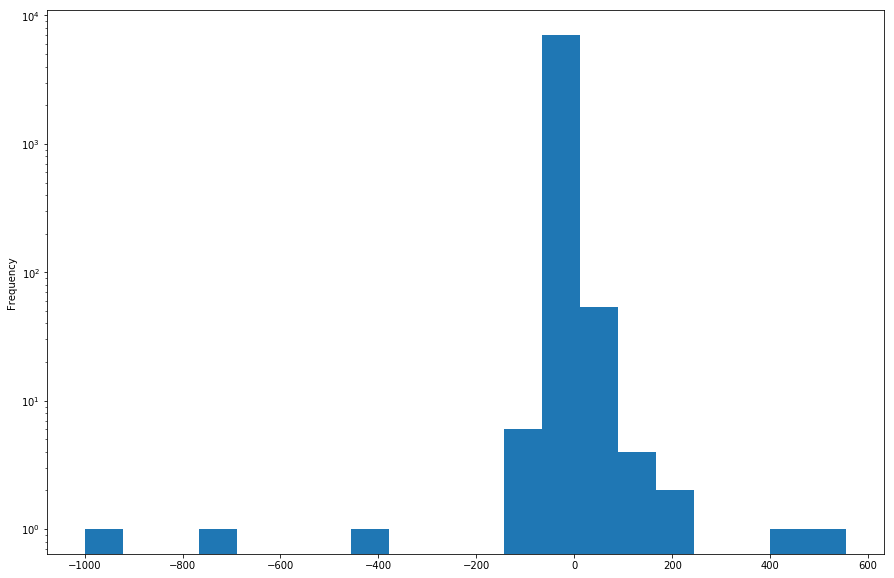

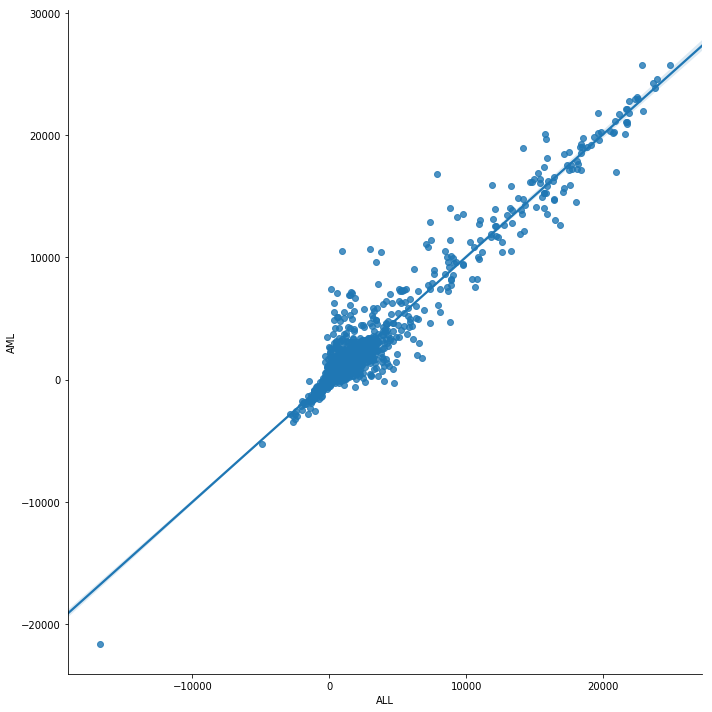

In [7]:
#idx = pd.IndexSlice
#means = df.loc[tuple(idx[:, 'mean']), :]

#Slice out just the means from the dataframe
means = df.loc[(slice(None), 'mean'), :]

#Reset the index and drop 'mean' column from dataframe
means.reset_index(level=1, inplace=True)
means.drop(columns='level_1', inplace=True)
print(means.head())
print(means.shape)

#Identify data where either ALL or AML mean is 0 and print to inspect data
AML_zero = means[means.AML == 0]
print(AML_zero)
ALL_zero = means[means.ALL == 0]
print(ALL_zero)

#Drop rows where either ALL or AML is zero from the dataframe
means = means[(means.ALL != 0) & (means.AML != 0)]

#Calculate the ratio of ALL mean to AML mean for all nonzero data
means.loc[:, 'Ratio'] = means['ALL'] / means['AML']
#Plot histogram of the ALL/AML mean ratios
means['Ratio'].plot(kind='hist', bins=20, logy=True, figsize=(15,10))

sns.lmplot(x='ALL', y='AML', data=means, height=10)
plt.show()

In [8]:
#Examine outlier from linear regression plot where ALL mean is < -10000
print(means[means.ALL < -10000])
print(df.loc['HG2887-HT3031_at'])
#The ratio of ALL mean to AML mean suggests that this gene is expressed similarly in both ALL and AML cancers, 
#so it can be excluded from further analysis
means = means[means.ALL > -10000]

cancer                     ALL           AML     Ratio
HG2887-HT3031_at -16775.407407 -21587.818182  0.777077
cancer           ALL           AML
count      27.000000     11.000000
mean   -16775.407407 -21587.818182
std      5581.288818   5939.622594
min    -27570.000000 -28400.000000
25%    -20116.000000 -26444.500000
50%    -17179.000000 -23645.000000
75%    -12677.000000 -17445.000000
max     -7397.000000  -9501.000000


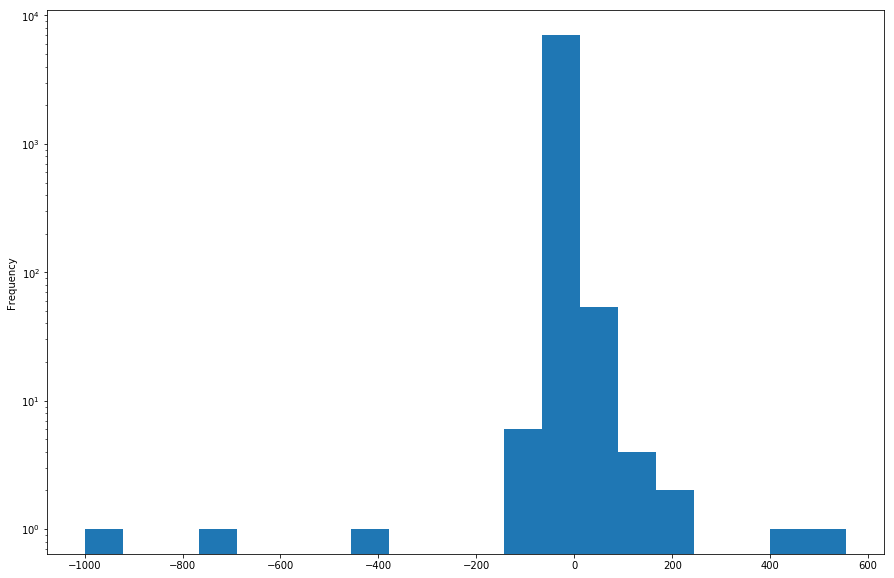

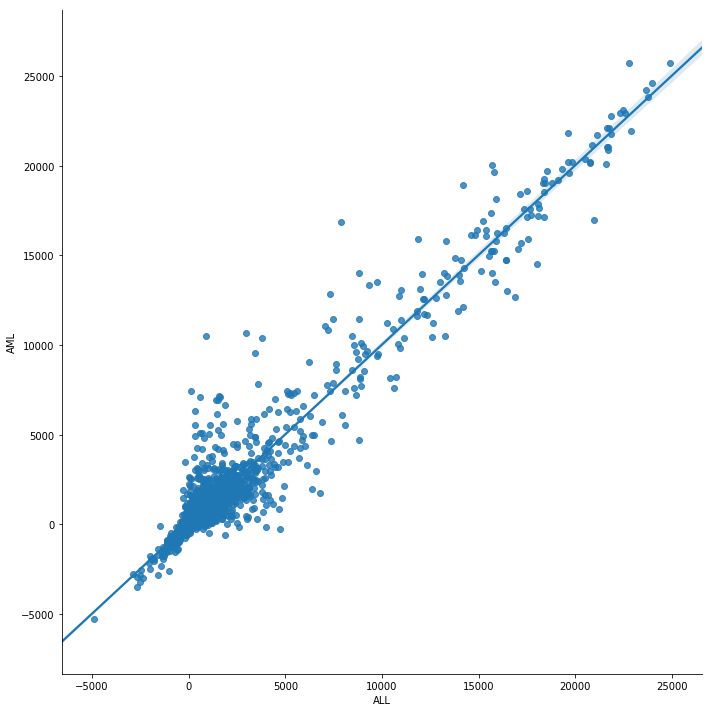

In [9]:
#Re-plot histogram and linear regression of ratios
means['Ratio'].plot(kind='hist', bins=20, logy=True, figsize=(15,10))
sns.lmplot(x='ALL', y='AML', data=means, height=10)
plt.show()

(7124, 3)
(1711, 3)
(259, 3)
(5, 3)
cancer              ALL       AML       Ratio
M54992_at    531.518519 -1.272727 -417.621693
U46006_s_at  257.074074 -0.363636 -706.953704
U50929_at    -39.037037 -0.090909  429.407407
U79285_at    302.703704  0.545455  554.956790
U91985_at    181.629630 -0.181818 -998.962963
cancer                          ALL         AML     Ratio
AC000066_at               -1.555556  -18.909091  0.082265
AF000430_at               -0.703704   16.818182 -0.041842
AF005361_at                0.888889  -23.000000 -0.038647
AFFX-HUMTFRR/M11507_M_at  23.629630  330.909091  0.071408
AFFX-TrpnX-5_at            0.407407   23.818182  0.017105


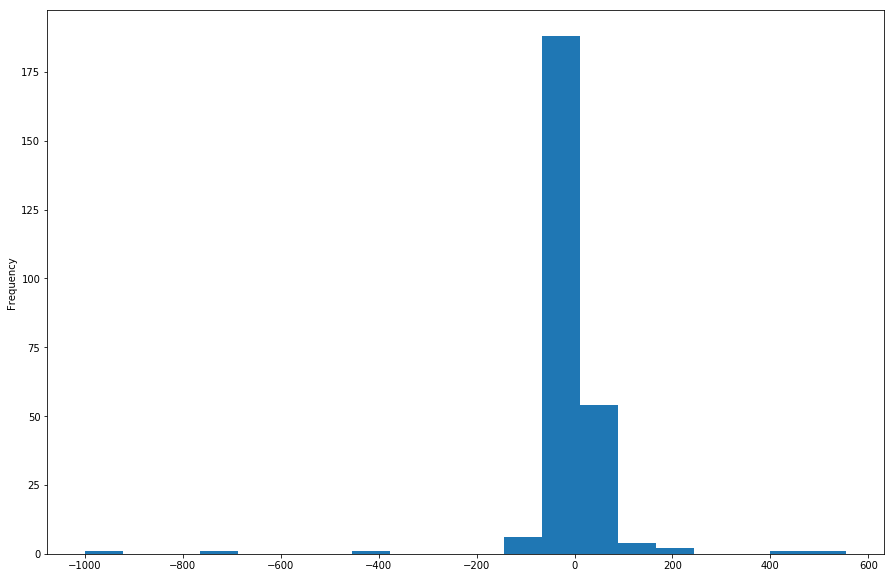

In [10]:
print(means.shape)
#Shows that there are 7124 genes currently in the data set

#Filter out all data where ALL/AML mean ratio is between 0.5 to 2 - a two-fold or more difference
low_ratios = means[(abs(means.Ratio) <= 0.5) | (abs(means.Ratio) >= 2)]
print(low_ratios.shape)
#There are now 1711 genes remaining in the data set - still too many genes

#Select data where there is a 10-fold difference between AML and ALL means, i.e. ratio is less than 0.1 or more than 10
high_ratios = means[(abs(means.Ratio) <= 0.1) | (abs(means.Ratio) >= 10)]
print(high_ratios.shape)
#Plot distribution of high_ratios
high_ratios['Ratio'].plot(kind='hist', bins=20, figsize=(15,10))

#Examine data with ratios > 300 or < -300
outlier_ratios = means[abs(means.Ratio) > 300]
print(outlier_ratios.shape)
print(outlier_ratios)
print(high_ratios.head())

Based on what I have seen of the data thus far, I also need to filter by overall expression level and not just the ALL/AML mean ratio, as genes with very low expression levels can have very large ratios.

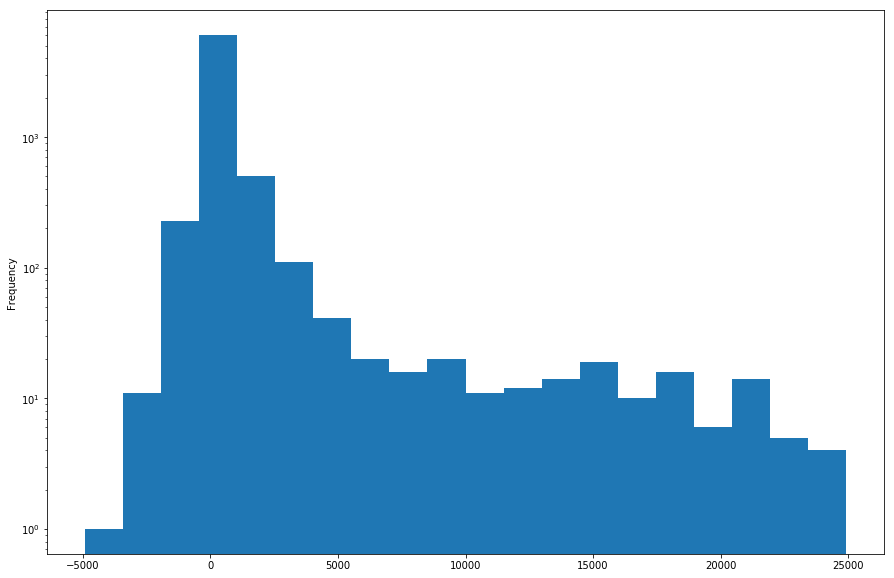

In [11]:
means['ALL'].plot(kind='hist', bins=20, logy=True, figsize=(15,10))

I need a measure of the correlation between a gene and the cancer type in order to identify the genes that are most highly correlated with each cancer type. To generate an estimate of the correlation, I can calculate the difference in the means between the AML samples and the ALL samples for each gene:

$$ \mu_{ALL} - \mu_{AML} $$

I also need to account for the variation of gene expression within each cancer type - to do this, I can calculate the difference in the means relative to the standard deviation for each cancer type:

$$ (\mu_{ALL} - \mu_{AML}) / (\sigma_{ALL} + \sigma_{AML}) $$

C:\Users\Caitlin\Miniconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Caitlin\Miniconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


cancer                   ALL         AML     ALL:AML
A28102_at   mean  258.555556  316.090909  -57.535354
            std   203.127723  126.132830  329.260553
AB000114_at mean   40.296296    6.090909   34.205387
            std    57.974673   31.007917   88.982590
AB000115_at mean  311.851852  319.090909   -7.239057
               mean_diff     std_sum  correlation
A28102_at     -57.535354  329.260553    -0.174741
AB000114_at    34.205387   88.982590     0.384405
AB000115_at    -7.239057  808.988630    -0.008948
AB000220_at    -6.037037   94.399310    -0.063952
AB000381_s_at -12.026936  108.040811    -0.111318
(7129, 3)


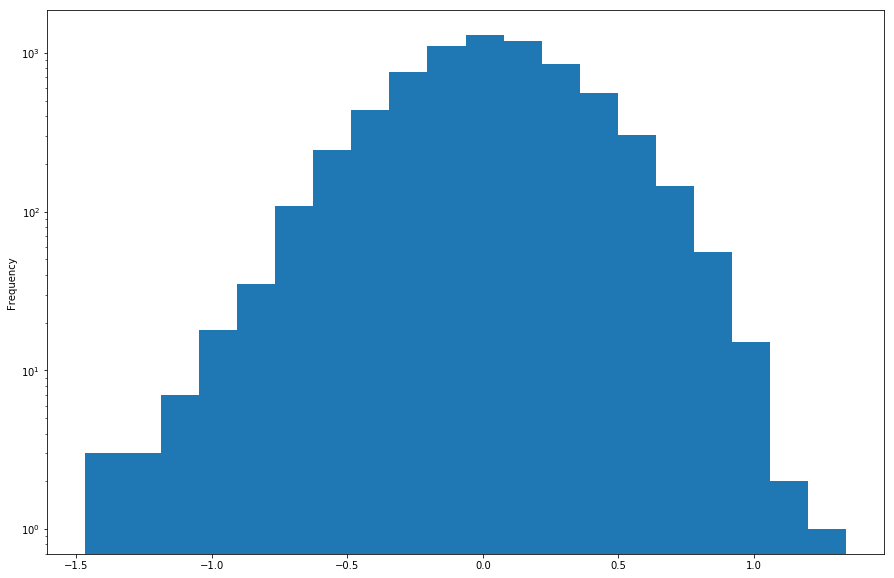

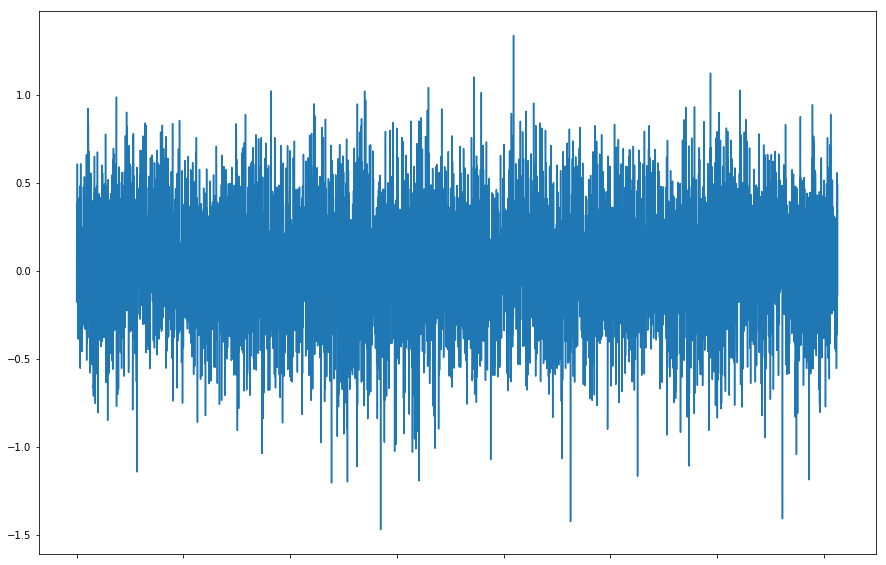

In [12]:
correlation = df.loc[(slice(None), slice('mean','std')), :]

#Calculate the difference of ALL mean to AML mean for all genes
correlation.loc[(slice(None), 'mean'), 'ALL:AML'] = (correlation['ALL'] - correlation['AML'])
correlation.loc[(slice(None), 'std'), 'ALL:AML'] = (correlation['ALL'] + correlation['AML'])
print(correlation.head())


mean_diff = correlation.loc[(slice(None), 'mean'), 'ALL:AML']
mean_diff = mean_diff.reset_index(level=1)
mean_diff.drop(columns='level_1', inplace=True)
std_sum = correlation.loc[(slice(None), 'std'), 'ALL:AML']
std_sum = std_sum.reset_index(level=1)
std_sum.drop(columns='level_1', inplace=True)

df_corr = pd.concat([mean_diff, std_sum], axis=1)
df_corr.columns = ['mean_diff', 'std_sum']

#Create a new column of the mean difference (mean_diff) over the standard deviation difference (std_diff) for each gene
df_corr.loc[:, 'correlation'] = (df_corr.mean_diff / df_corr.std_sum)
print(df_corr.head())
print(df_corr.shape)

#Plot a histogram and line plot of the correlation for each gene
df_corr['correlation'].plot(kind='hist', bins=20, logy=True, figsize=(15,10))
plt.show()
df_corr['correlation'].plot(kind='line', figsize=(15,10))
plt.show()

In [13]:
#I want to concat the previous means dataframe so I can see the ALL_mean and AML_mean for each gene as well
#First, I will recreate the 'means' dataframe from earlier and rename the columns
means_both = df.loc[(slice(None), 'mean'), :]
means_both.reset_index(level=1, inplace=True)
means_both.drop(columns='level_1', inplace=True)
means_both.columns = ['ALL_mean', 'AML_mean']

#Next I will do the same thing to slice out the standard deviations and rename the columns
stdev = df.loc[(slice(None), 'std'), :]
stdev.reset_index(level=1, inplace=True)
stdev.drop(columns='level_1', inplace=True)
stdev.columns = ['ALL_stdev', 'AML_stdev']

#Finally, I will concat the df_corr, means_both, and stdev dataframes together into one dataframe
gene_summary = pd.concat([means_both, stdev, df_corr], axis=1)
print(gene_summary.head())

                 ALL_mean    AML_mean   ALL_stdev   AML_stdev  mean_diff  \
A28102_at      258.555556  316.090909  203.127723  126.132830 -57.535354   
AB000114_at     40.296296    6.090909   57.974673   31.007917  34.205387   
AB000115_at    311.851852  319.090909  464.190006  344.798624  -7.239057   
AB000220_at     34.962963   41.000000   31.709598   62.689712  -6.037037   
AB000381_s_at   48.518519   60.545455   50.803824   57.236987 -12.026936   

                  std_sum  correlation  
A28102_at      329.260553    -0.174741  
AB000114_at     88.982590     0.384405  
AB000115_at    808.988630    -0.008948  
AB000220_at     94.399310    -0.063952  
AB000381_s_at  108.040811    -0.111318  


In [14]:
top_genes = gene_summary[abs(gene_summary.correlation) >= 0.9]
print(top_genes.shape)
print(top_genes)

(55, 7)
                     ALL_mean      AML_mean    ALL_stdev    AML_stdev  \
AF009426_at         67.851852    -49.000000    92.587050    33.790531   
D26156_s_at       1306.000000    578.818182   520.503381   214.693651   
D38073_at          913.407407    324.727273   473.186031   178.768616   
D49950_at           75.370370    243.909091    54.687327    93.180958   
J03801_f_at       1513.111111   6942.909091  1104.767164  4900.873727   
L08246_at         1066.555556   3767.454545   668.587566  1941.522051   
L13278_at          127.925926      0.545455    93.867716    30.559331   
L47738_at         1251.740741    192.727273   897.851649   216.420928   
M11147_at         7885.370370  16838.090909  3956.120245  5236.035799   
M16038_at          375.370370   1811.636364   240.297436   953.688238   
M19045_f_at       1559.851852   7160.454545  1185.647331  4784.661521   
M21551_rna1_at     229.074074    464.000000   138.856020   115.326493   
M23197_at          175.037037    767.272727

Index(['AF009426_at', 'D26156_s_at', 'D38073_at', 'L13278_at', 'L47738_at',
       'M28170_at', 'M31211_s_at', 'M31523_at', 'M91432_at', 'M92287_at',
       'S50223_at', 'U05259_rna1_at', 'U09087_s_at', 'U22376_cds2_s_at',
       'U29175_at', 'U32944_at', 'X15949_at', 'X52142_at', 'X59417_at',
       'X63469_at', 'X74262_at', 'Z15115_at'],
      dtype='object')


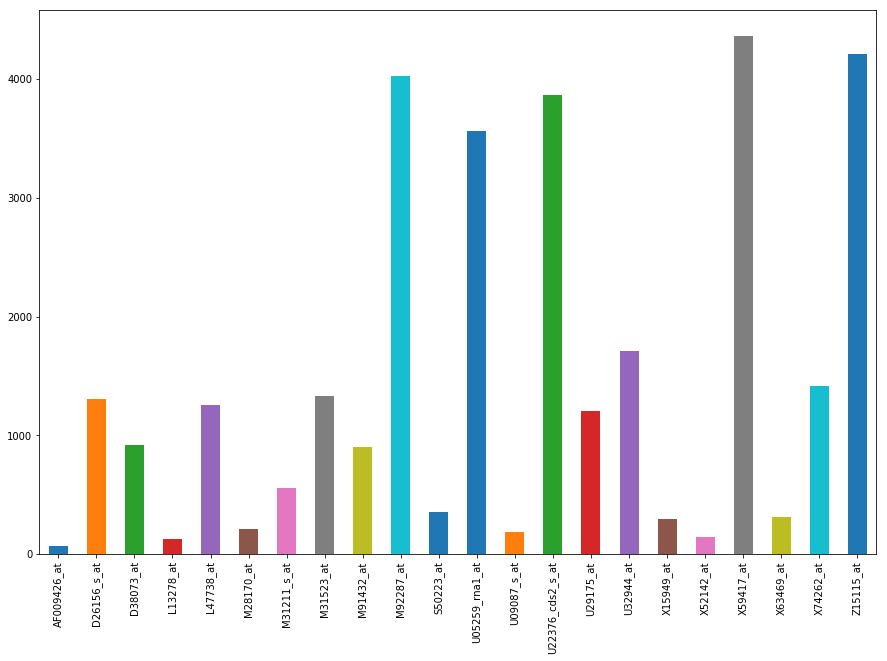

Index(['D49950_at', 'J03801_f_at', 'L08246_at', 'M11147_at', 'M16038_at',
       'M19045_f_at', 'M21551_rna1_at', 'M23197_at', 'M27891_at',
       'M28130_rna1_s_at', 'M55150_at', 'M57710_at', 'M62762_at', 'M63138_at',
       'M69043_at', 'M80254_at', 'M81695_s_at', 'M81933_at', 'M83652_s_at',
       'M84526_at', 'M96326_rna1_at', 'U12471_cds1_at', 'U46751_at',
       'U50136_rna1_at', 'U82759_at', 'X04085_rna1_at', 'X14008_rna1_f_at',
       'X17042_at', 'X58431_rna2_s_at', 'X85116_rna1_s_at', 'X95735_at',
       'Y00787_s_at', 'Y12670_at'],
      dtype='object')


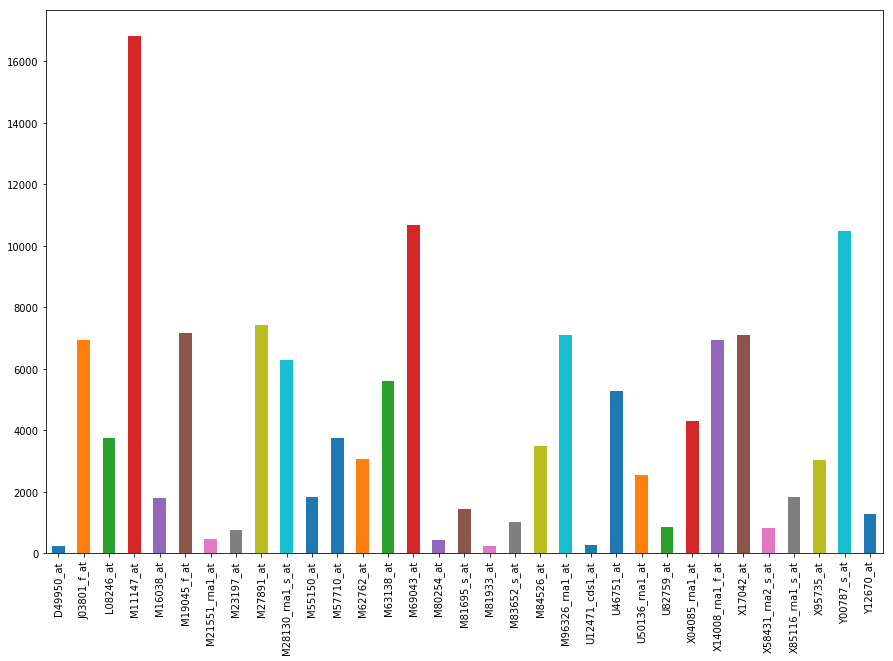

In [15]:
top_genes_ALL = top_genes[top_genes.correlation >= 0.9]
top_genes_AML = top_genes[top_genes.correlation <= 0.9]
print(top_genes_ALL.index)
top_genes_ALL['ALL_mean'].plot(kind='bar', figsize=(15,10))
plt.show()
print(top_genes_AML.index)
top_genes_AML['AML_mean'].plot(kind='bar', figsize=(15,10))
plt.show()